### Knowledge Graphs + Code + LLMs

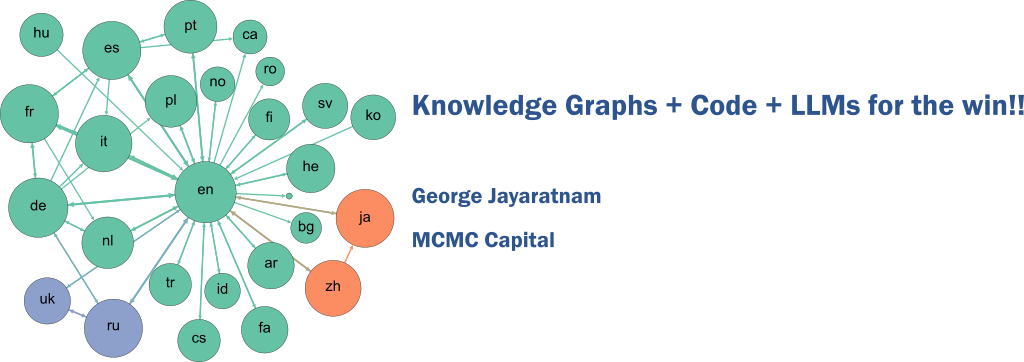

In [1]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/title.png"

# Display the PNG file
Image(filename=png_path)

### Summary

**The problem:** How to understand / piece together a large unfamiliar codebase when there is:
- Missing, scant, and sometimes inaccurate documentation
- Mixed use of technologies and frameworks + legacy code
- No easy way of tracking connected files, function, parameters, etc.
- No natural language explanation of code blocks  

**The solution:** This notebook shows how to use a knowledge graph to analyse connected data like a large codebase. The key features 
- Works primarily with metadata
- Ingest metadata into the graph quickly and start asking questions
- As more questions are triggered, the graph is progressively enhanced
- LLMs are used to help with an initial 'understanding' of what the code does
- Control over the input token limits of the LLM are managed via the graph queries 
- Although the demo is based on the teardown of a particular application (Zotero), the approach is generalisable to any codebase irrespective of size, language, tech stack, etc.

### Notebook summary: LLMs + Knowledge Graphs + Code

1. Knowledge graph (KG) basics
    - Basic concepts
    - Storage options


2. My use case: Improving Zotero's search capability
    - Hacking a complex codebase!
    - Knowledge graph design 


3. Part 1: A KG for the data layer
    - What are my questions
    - Buildling a knowledge graph on top of a RDBMS


4. Part 2: A KG for the application layer
    - Abstract Syntax Trees (AST)
    - Working with the Github Search API
    - LLMs to help with ***initial*** code explanations


5. Part 3: A KG for the business domain layer
    - GraphRAG for text
    - Public ontologies

   
6. Key takeways + Resources

### The big picture

###### Diagram: What I'm trying to build

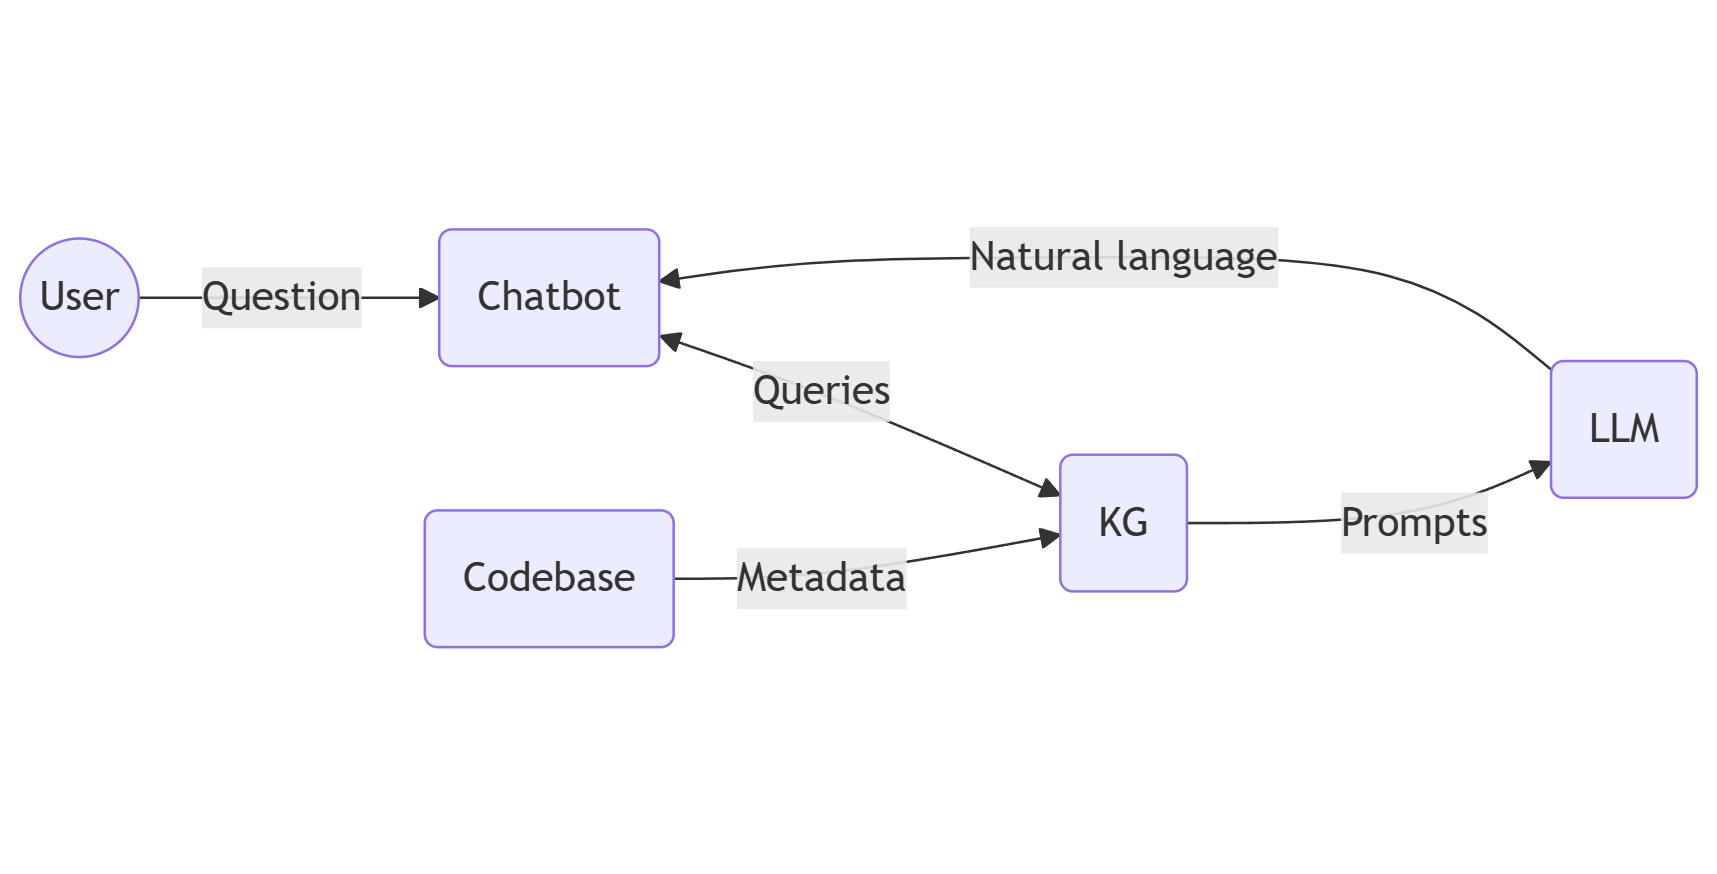

In [4]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/bigPicture.png"

# Display the PNG file
Image(filename=png_path)

This knowledge graph demo is designed to be a federation of 3 separate knowledge graphs - the Data KG (Part 1), the Application KG (Part 2), and the Business KG (Part 3).

Each KG ingests metadata from different sources and caters to questions about their respective layer. 

###### Diagram: Structured data - creating the Data and Application KGs

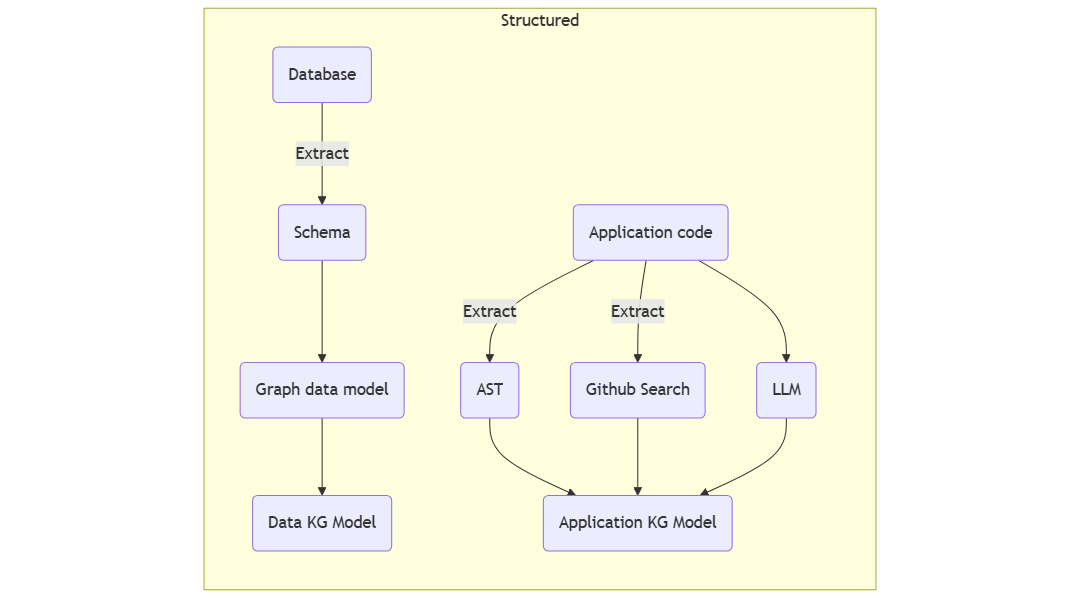

In [5]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/structuredOverview.png"

# Display the PNG file
Image(filename=png_path)

###### Diagram: Unstructured data - creating the Business Domain KGs

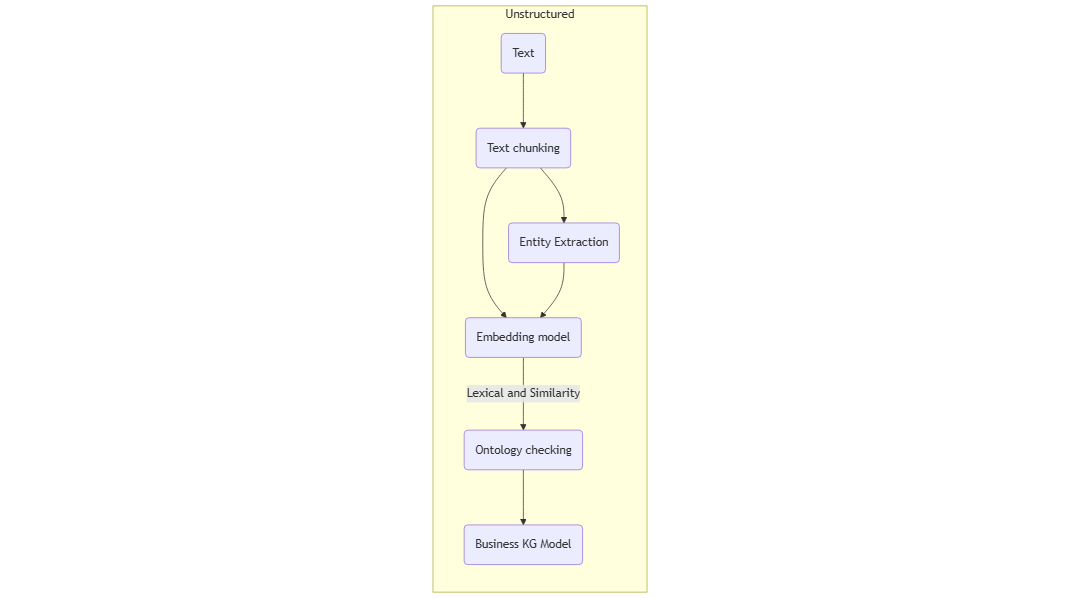

In [6]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/unstructuredOverview.png"

# Display the PNG file
Image(filename=png_path)

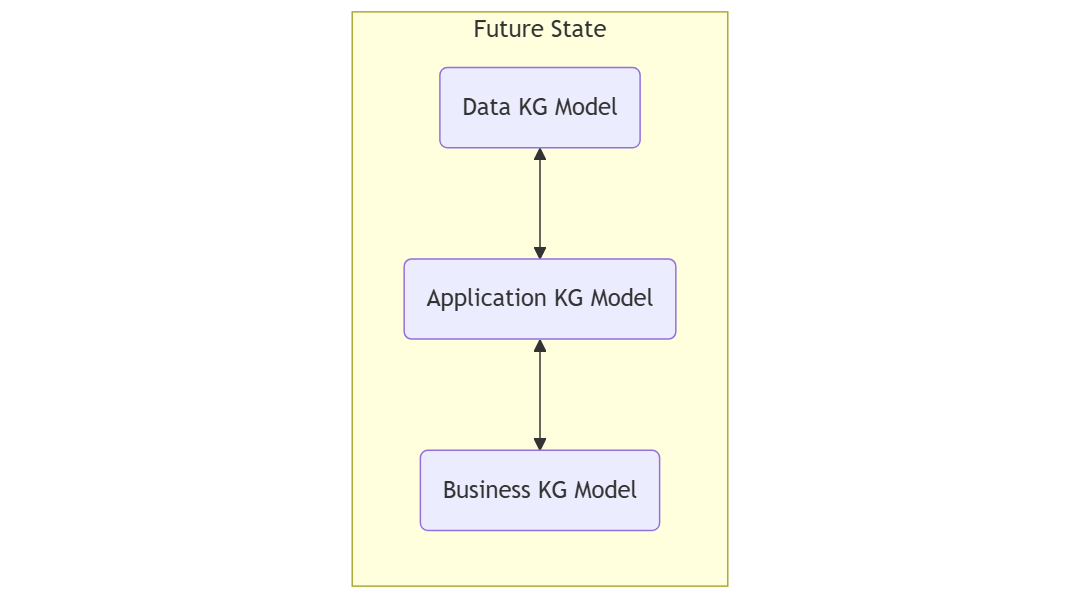

In [8]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/combined.png"

# Display the PNG file
Image(filename=png_path)

*Diagrams inspired by the work of [Paco Nathan](https://www.youtube.com/watch?v=B6_NfvQL-BE), a KG industry guru*

### 1. Knowledge graph (KG) 

###### What are knowledge graphs?

> "Knowledge graphs are a way of organizing and representing information in a machine-readable format. A knowledge graph represents a collection of real-world concepts (displayed as nodes) and relationships (displayed as edges) in the form of a graph used to link and integrate data coming from diverse sources."
> 
> `-` [data.world](https://data.world/blog/what-is-a-knowledge-graph/)


*My take* - Just a way of representing knowledge to:


1. Answer questions - context


2. Able to be read by machines/code


3. Is accurate - traceability


4. Easily updatable - new learning/refactor

###### Storage options

Many ways to store a knowledge graph:


1. Graph databases

   1. Neo4j
         
   2. Janus (open source)

   3. TigerGraph

    
2. RDF triplestores

   1. Blazegraph (Wikipedia)
   
   2. GraphDB (Ontotext)
     
   3. PoolParty


3. Elasticsearch - requires plugins


4. RDBMS - MySQL at Facebook (2004)  

###### Neo4j example 

- Graph example from Neo4j


- Data from the 
[StackOverflow Questions API](https://neo4j.com/graphgists/1a1d669d-8f35-485c-afe7-b4e0bf45d7d7/)


- Ingested into a Neo4j graph model

###### Neo4J - Why I ended up choosing them

- Build my own PageRank for contextual text search


- Started with Elasticsearch


- Neo4j easiest to get onboarded


- Free local and cloud options


- Query syntax (Cypher) similar to SQL


- Cypher moving to W3C standard - can work with other compliant graph DBs 
(SAP HANA 
Graph)

###### Neo4j example 

- Graph example from Neo4j


- Data from the 
[StackOverflow Questions API](https://neo4j.com/graphgists/1a1d669d-8f35-485c-afe7-b4e0bf45d7d7/)


- Ingested into a Neo4j graph model

###### Code: Setup environment and cypher query function

In [26]:
# Setup env and key query function
from dotenv import load_dotenv
from neo4j import GraphDatabase
from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget
import os
import pandas as pd
import requests
import time
import base64
import subprocess
import json
import pickle
import datetime
import pytz
import re
import ast
from langchain_openai import ChatOpenAI
from langchain_neo4j import Neo4jGraph, GraphCypherQAChain
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.prompts import PromptTemplate, FewShotPromptTemplate
import gradio as gr

load_dotenv()

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = os.getenv("NEO4J_URI")
AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
UN = os.getenv("NEO4J_USERNAME")
PW = os.getenv("NEO4J_PASSWORD")
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")


# Define a function to run a Cypher query   
def run_cypher_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters)
        # Fetch and return the results
        return result.data()

###### Code: Stackoverflow graph schema: View, Nodes, Counts

In [2]:
# Generic function to run Cypher queries
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='stackoverflow') as driver:
    driver.verify_connectivity()
    print("Connection established.")

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

    # Query to list all nodes and their properties
    query_stack_nodes = """
    CALL db.schema.nodeTypeProperties() 
    YIELD nodeType, propertyName 
    RETURN nodeType AS label, COLLECT(propertyName) AS properties
    """
    result_query_stack_nodes = run_cypher_query(query_stack_nodes)
    df_result_query_stack_nodes = pd.DataFrame(result_query_stack_nodes)
    print(f"Results: query_stack_nodes\n{df_result_query_stack_nodes}\n")

    # Query to print a sample of 5 records from the Tag node
    query_tag_sample = """
    MATCH (t:Tag)  
    RETURN t AS tag_props 
    LIMIT 5;
    """
    result_query_tag_sample = run_cypher_query(query_tag_sample)
    df_result_query_tag_sample = pd.DataFrame(result_query_tag_sample)
    print(f"Results: query_tag_sample\n{df_result_query_tag_sample}\n")

    # Query to count the frequency of nodes
    query_stack = """
    MATCH (n)
    RETURN labels(n) AS label, count(*) AS count
    ORDER BY count DESC;
    """

    result_stack = run_cypher_query(query_stack)
    df_stack_nodes = pd.DataFrame(result_stack)
    # Flatten the 'label' column since it's a list
    df_stack_nodes['label'] = df_stack_nodes['label'].apply(lambda x: x[0] if len(x) > 0 else None)
    print(f"Results: df_stack_nodes['label']\n{df_stack_nodes}\n")  # Outputs the list of nodes (Persons)

# Close the driver
driver.close()

Connection established.


GraphWidget(layout=Layout(height='500px', width='100%'))

Results: query_stack_nodes
         label                                         properties
0      :`User`                               [uuid, display_name]
1       :`Tag`                                       [name, link]
2    :`Answer`  [uuid, title, link, is_accepted, body_markdown...
3   :`Comment`                                [uuid, link, score]
4  :`Question`  [uuid, title, creation_date, accepted_answer_i...

Results: query_tag_sample
                                           tag_props
0  {'name': 'neo4j', 'link': 'https://stackoverfl...
1  {'name': 'subgraph', 'link': 'https://stackove...
2  {'name': 'graph', 'link': 'https://stackoverfl...
3  {'name': 'cypher', 'link': 'https://stackoverf...
4  {'name': 'graph-databases', 'link': 'https://s...

Results: df_stack_nodes['label']
      label  count
0  Question   1589
1   Comment   1396
2    Answer   1367
3      User   1365
4       Tag    476



###### Diagram: Stackoverflow schema - from code result

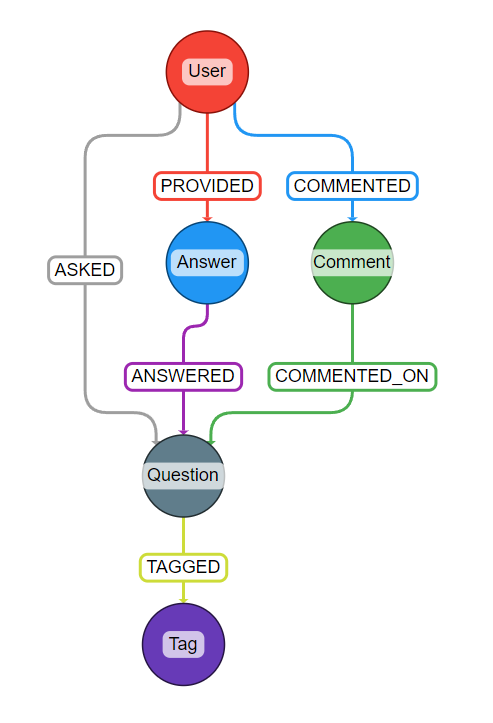

In [6]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/stackoverflow_schema.png"

# Display the PNG file
Image(filename=png_path)

So what types of questions can we answer from this schema?


**Question: "How are tags related to other tags?"**


```
    MATCH (t1:Tag)<-[:TAGGED]-()-[:TAGGED]->(t2:Tag)
    WHERE t1.name < t2.name AND t1.name <> 'neo4j' AND t2.name <> 'neo4j'
    RETURN t1.name AS TAG_1, t2.name AS TAG_2 , count(*) AS freq
    ORDER BY freq DESC LIMIT 10;
```


* Each tag is a unique instance of the `Tag` node 


Answer **requires multiple joins** via the Question Node.

###### Code: Query to calculate the frequency of the top 10 tag-pairs

In [7]:
# import pandas as pd
# from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget

with GraphDatabase.driver(URI, auth=AUTH, database='stackoverflow') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")

    # Question: "How are tags related to other tags"
    query_tags = """
    MATCH (t1:Tag)<-[:TAGGED]-()-[:TAGGED]->(t2:Tag)
    WHERE t1.name < t2.name AND t1.name <> 'neo4j' AND t2.name <> 'neo4j'
    RETURN t1.name AS TAG_1, t2.name AS TAG_2 , count(*) AS freq
    ORDER BY freq DESC LIMIT 10;
    """

    result_tags = run_cypher_query(query_tags)
    df_result_tags = pd.DataFrame(result_tags)
    # Flatten the 'label' column since it's a list
    # df_result_4['label'] = df_result_4['label'].apply(lambda x: x[0])
    print(f"Tag-pair frequency\n{df_result_tags}\n")  # Outputs the list of tag-pair frequencies

driver.close()

Neo4j connection established.
Tag-pair frequency
    TAG_1            TAG_2  freq
0  cypher       neo4j-apoc    86
1  cypher  graph-databases    79
2  cypher            graph    46
3  cypher           python    32
4  cypher         database    30
5  cypher             java    29
6  cypher       redisgraph    27
7  py2neo           python    20
8  cypher          graphql    17
9    java           spring    17



###### Key points: Representing knowledge in a graph database

1. Both nodes and relationships can have multiple properties - numbers, text,
 dates


2. Two nodes can have multiple relationships between them


3. Graph databases have a schema but they are flexible / easy to refactor


4. Graph schema design depends on the types of questions you want to ask 


5. Suited for questions/queries where the intermediate nodes are not known - 
multi-hop


6. Pre-processing data prior to ingestion may require some effort

### 2. My use case: Improving Zotero's search capability

- Widely used Citation Management tool in the accademic and research community


- Drag-n-drop content storage (PDF, URLs, Youtube, RSS etc).


- **70+ data connectors**: PDFs, websites, wikis, aggregator sites, news sites 


- Search experience:
    - Manual tagging
    - No in-content search - PDFs only if you sync with Zotero Cloud
    - No control over tag weights or search result ranking
    - Tag management


- Build my own search ranking engine on top of Zotero data

###### Diagram: What I'm trying to do

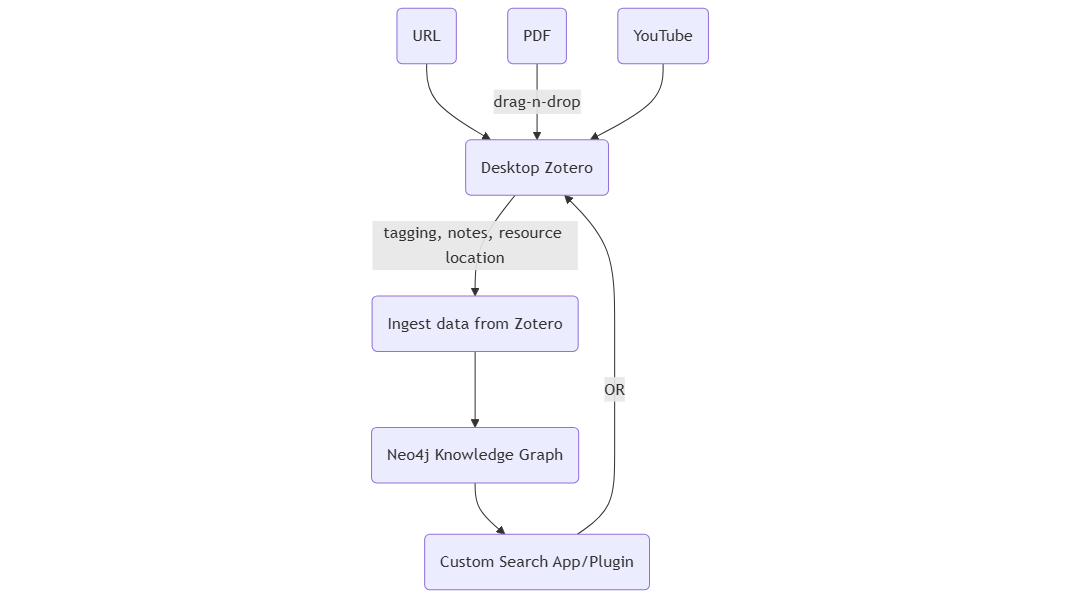

In [8]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/zoteroWorkflow.png"

# Display the PNG file
Image(filename=png_path)

###### Hacking a complex codebase: Can connected data help?

- Zotero's documentation doesn't really explain the codebase


- I need to start from ground-zero


1. What are the basics
    - How and where is the data kept?
    - How does the codebase work - any framework used?


2. How is the codebase connected right across the stack?
    - What does the data model look like?
    - How does the application talk to the database?
    - How do the various classes, functions and parameters relate to each other?  

### 3. Part 1: A KG for the data layer

#### When a DBMS is the data store, the schema + stored functions hold the key

- Zotero uses [SQLite](https://www.zotero.org/support/dev/client_coding/direct_sqlite_database_access) as its database


- However content is stored in individual hashed folders in the `Users` directory


- **My question:** How do I go from where the tags in the database to the actual location for each piece of content?


- For that I need to know:

    1. Which table holds the tags
    2. Which table holds the information about the content and its' hashed storage location
    3. **How are the tables connected?**

###### Diagram: Data pipeline to ingest SQLite metadata into Neo4J

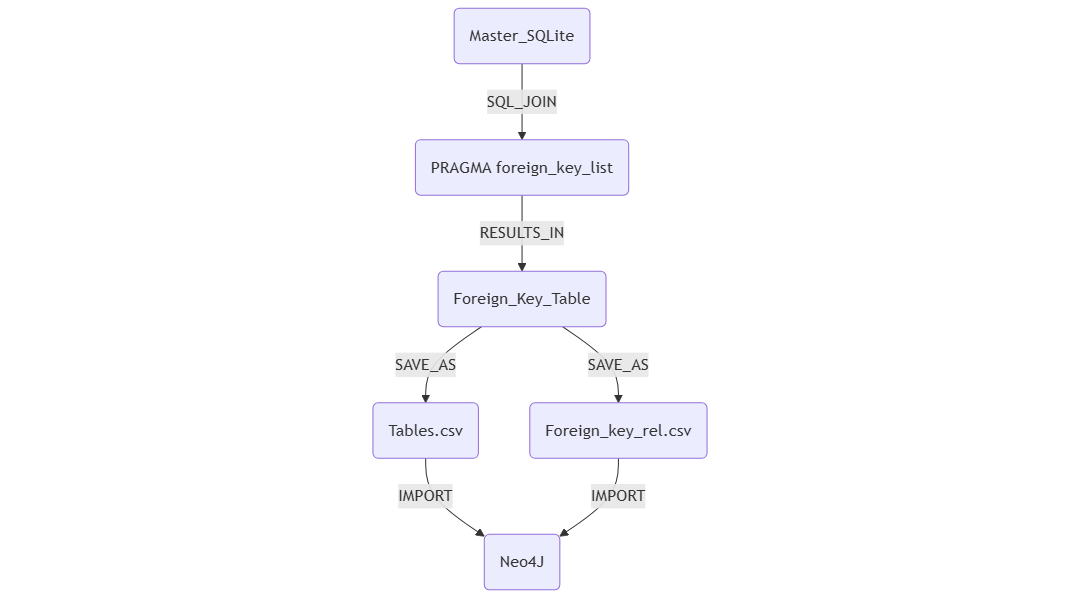

In [13]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/dataKGCodeFlow.png"

# Display the PNG file
Image(filename=png_path)

###### Connect to the db file `zotero.sqlite` for schema queries

###### Code: Check SQLite db connection

In [9]:
import sqlite3

# Connect to the SQLite database
with sqlite3.connect('C:\\Users\\georg\\Zotero\\zotero.sqlite') as sqliteConnection:
    cursor = sqliteConnection.cursor()
    print("Connected to Zotero SQLite")

    sqlite_select_Query = "select sqlite_version();"
    cursor.execute(sqlite_select_Query)
    record = cursor.fetchall()
    print("SQLite Database Version is: ", record)
    # Close cursor
    cursor.close()

# SQLite connection object will persist if not closed manually:
sqliteConnection.close()

# Check if cursor is still open due:
try:
    cursor.execute('SELECT 1')  # Will raise an error if connection is closed
    print("Cursor still open.")
except sqlite3.ProgrammingError:
    print("Cursor closed.")

# Check if connection is closed:
try:
    sqliteConnection.execute('SELECT 1')  # Will raise an error if connection is closed
    print("Connection still open.")
except sqlite3.ProgrammingError:
    print("SQLite connection is closed.")

Connected to Zotero SQLite
SQLite Database Version is:  [('3.45.3',)]
Cursor closed.
SQLite connection is closed.


###### Code: Extract data dictionary from `sqlite_master` table

In [11]:
# If the Zotero application is open, the database will be locked. Close it first.

# Create new SQLite connection
with sqlite3.connect('C:\\Users\\georg\\Zotero\\zotero.sqlite') as sqliteConnection:
    cursor = sqliteConnection.cursor()
    print("Connected to Zotero SQLite")
    cursor.execute('PRAGMA table_info(sqlite_master);')
    columns = [column[1] for column in cursor.fetchall()]
    print(columns)

    # Frequency count of type column
    query_schema_obj = """
        SELECT type, COUNT(*) AS frequency
        FROM sqlite_master
        GROUP BY type
        
        UNION ALL

        SELECT 'Total', COUNT(*)
        FROM sqlite_master
    """
    df_schema_obj_count = pd.read_sql_query(query_schema_obj, sqliteConnection)
    print(df_schema_obj_count)

    # Close cursor
    cursor.close()

# Close connection    
sqliteConnection.close()

Connected to Zotero SQLite
['type', 'name', 'tbl_name', 'rootpage', 'sql']
      type  frequency
0    index         84
1    table         61
2  trigger         12
3    Total        157


###### Code: Query (Neo4j) to view schema, count nodes

In [12]:
with GraphDatabase.driver(URI, auth=AUTH, database='sqlite') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")

    # Query to count nodes and relationships in Neo4j
    query_sqlite_nodes = """
    MATCH (n)
    RETURN labels(n) AS label, count(*) AS count
    ORDER BY count DESC;
    """
    result_query_sqlite_nodes = run_cypher_query(query_sqlite_nodes)
    # Convert the list of dictionaries to a pandas DataFrame
    df_result_query_sqlite_nodes = pd.DataFrame(result_query_sqlite_nodes)
    # Flatten the 'label' column since it's a list
    df_result_query_sqlite_nodes['label'] = df_result_query_sqlite_nodes['label'].apply(
        lambda x: x[0] if len(x) > 0 else None)
    print(f"Frequency count of node:\n{df_result_query_sqlite_nodes}\n")  # Outputs the list of nodes
    print(f"Check table count is the same as SQLite metadata query.\n")

    query_sqlite_relationships = """
    MATCH ()-[r]->()
    RETURN type(r) AS relationshipType, COUNT(r) AS frequency
    ORDER BY frequency DESC;
    """

    result_query_sqlite_relationships = run_cypher_query(query_sqlite_relationships)
    df_result_query_sqlite_relationships = pd.DataFrame(result_query_sqlite_relationships)
    print(
        f"Frequency count of relationship:\n{df_result_query_sqlite_relationships}\n")  # Outputs the list of relationships

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

# Close the driver
driver.close()

Neo4j connection established.
Frequency count of node:
    label  count
0  Column    115
1   Table     61

Check table count is the same as SQLite metadata query.

Frequency count of relationship:
  relationshipType  frequency
0       HAS_COLUMN        236
1         CHILD_FK         63
2        PARENT_FK         22



GraphWidget(layout=Layout(height='500px', width='100%'))

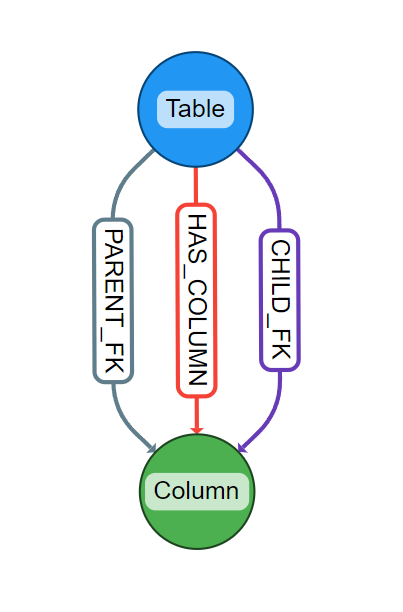

In [14]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/dataKGSchema.png"

# Display the PNG file
Image(filename=png_path)

#### The graph model can now answer questions about how tables are connected

For example:
What's the shortest join path between the **'tags'** and **'items'** tables?

###### Code: Query Neo4j to see how 2 tables are connected

In [146]:
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='sqlite') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")

    # The shortest join path between the 'tags' and 'items' tables
    query_path = """
    MATCH path = shortestPath((t1:Table {name: 'tags'})-[:PARENT_FK|CHILD_FK*]-(t2:Table {name: 'items'}))
    RETURN path;
    """
    
    result_path = run_cypher_query(query_path)
    
    if len(result_path) == 0:
        print("No paths were returned.")
    else:
        result_path_df = pd.DataFrame(result_path)
        print(f"Full path result:\n{result_path_df}\n")
        # Generate graph from Cypher query
        g = Neo4jGraphWidget(driver)
        g.show_cypher(query_path)

# Close the driver
driver.close()

Neo4j connection established.
Full path result:
                                                path
0  [{'name': 'tags'}, PARENT_FK, {'name': 'tagID'...



GraphWidget(layout=Layout(height='500px', width='100%'))

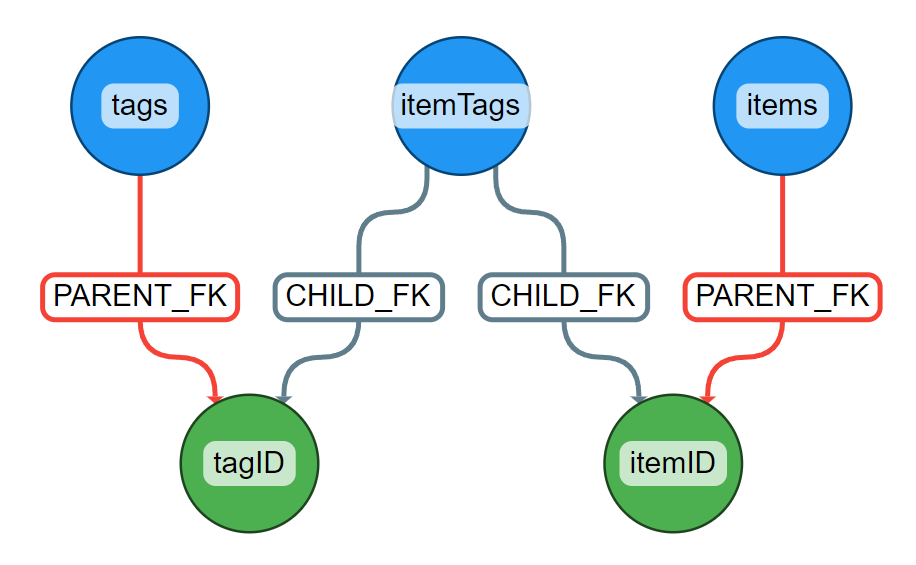

In [119]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/tagsToItemShortestPath.png"

# Display the PNG file
Image(filename=png_path)

###### Results summary

- The 'tags' and 'items' tables were specifically chosen given our initial business requirement


- Other join paths are possible by modifying the query - Cypher is designed to make graph traversal queries simple


- Can be extended to investigate other table joins

#### Overlay a chatbot to query the Data KG

Solving Data KG queries involves 3 steps:

1. What are the list of tables in the database?

2. What data does each selected table have?

3. What is the shortest join path for the 2 selected tables?

Tie it together in a Gradio chatbot. 

###### Code: 1. List of tables in the Data KG

In [133]:
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='sqlite') as driver:
    driver.verify_connectivity()
    print("Connection established.")
       
    query_table_list = """
    MATCH (t:Table)
    RETURN t;
    """
    result_query_table_list = run_cypher_query(query_table_list)
    # print(f'Current contents of:\n{result_query_table_list}\n')
    
    
    # Convert the list of dictionaries to a pandas DataFrame
    df_result_query_table_list = pd.DataFrame(result_query_table_list)
    # Flatten the 'label' column since it's a list
    table_name_list = df_result_query_table_list['t'].apply(lambda x: x["name"]).tolist()
    print(f'List of table names:\n{table_name_list}\n')


Connection established.
List of table names:
['version', 'baseFieldMappings', 'baseFieldMappingsCombined', 'charsets', 'collectionItems', 'collectionRelations', 'collections', 'creatorTypes', 'creators', 'customBaseFieldMappings', 'customFields', 'customItemTypeFields', 'customItemTypes', 'dbDebug1', 'deletedCollections', 'deletedItems', 'deletedSearches', 'feedItems', 'feeds', 'fieldFormats', 'fields', 'fieldsCombined', 'fileTypeMimeTypes', 'fileTypes', 'fulltextItemWords', 'fulltextItems', 'fulltextWords', 'groupItems', 'groups', 'itemAnnotations', 'itemAttachments', 'itemCreators', 'itemData', 'itemDataValues', 'itemNotes', 'itemRelations', 'itemTags', 'itemTypeCreatorTypes', 'itemTypeFields', 'itemTypeFieldsCombined', 'itemTypes', 'itemTypesCombined', 'items', 'libraries', 'proxies', 'proxyHosts', 'publicationsItems', 'relationPredicates', 'retractedItems', 'savedSearchConditions', 'savedSearches', 'settings', 'storageDeleteLog', 'syncCache', 'syncDeleteLog', 'syncObjectTypes', 'sy

###### Code: Get a sample of 5 record for a selected table

In [111]:
# Create new SQLite connection
with sqlite3.connect('C:\\Users\\georg\\Zotero\\zotero.sqlite') as sqliteConnection:
    cursor = sqliteConnection.cursor()
    print("Connected to Zotero SQLite")
    
    table_name = 'tags'  # Set the table name dynamically from Gradio selection
    print(f"Table name: {table_name}")
    
    # Dynamically construct the SQL query
    query = f"SELECT * FROM {table_name} LIMIT 5"
    
    cursor.execute(query)
    
    # Fetch column names
    columns = [desc[0] for desc in cursor.description]
    
    rows = cursor.fetchall()
    
    # Convert to Pandas DataFrame (optional)
    df_query_rows = pd.DataFrame(rows, columns=columns)
    print(df_query_rows)

    # Close cursor
    cursor.close()

# Close connection
print("SQLite connection closed")
sqliteConnection.close()

Connected to Zotero SQLite
Table name: tags
   tagID                 name
0      2            financial
1      9                UI/UX
2     10  marketing analytics
3     11               design
4     12      developer tools
SQLite connection closed


###### Code: Gradio chatbot to view table records

- To determine which tables are of interest

In [138]:
from IPython.display import display, Javascript

# Define a function that takes the selected item from the dropdown
def select_item(selected_table):
    
    # Create new SQLite connection
    with sqlite3.connect('C:\\Users\\georg\\Zotero\\zotero.sqlite') as sqliteConnection:
        cursor = sqliteConnection.cursor()
        # print("Connected to Zotero SQLite")
               
        # Dynamically construct the SQL query
        query = f"SELECT * FROM {selected_table} LIMIT 5"
        
        cursor.execute(query)
        
        # Fetch column names
        columns_gradio = [desc[0] for desc in cursor.description]
        
        rows_gradio = cursor.fetchall()
        
        # Convert to Pandas DataFrame (optional)
        df_query_rows_gradio = pd.DataFrame(rows_gradio, columns=columns_gradio)
        # print(df_query_rows_gradio)

        # Close cursor
        cursor.close()

    # Close connection
    # print("SQLite connection closed")
    
    return df_query_rows_gradio

# Create a Gradio Interface with a dropdown
demo = gr.Interface(
    fn=select_item, #Funtion to call
    inputs=gr.Dropdown(choices=table_name_list, label="Choose table:"),  # Dropdown input
    outputs=[gr.Dataframe(label="First 5 rows:")],                 # Output will be the selected option text
    flagging_mode="never",               # This disables flagging in Gradio 5+
    title="View individual table records",  # Title heading at the top of the interface
    live=False  # Disable live updates, so you have to submit manually
)

demo.launch()  # Disable flagging button

* Running on local URL:  http://127.0.0.1:7891

To create a public link, set `share=True` in `launch()`.


###### Code: Gradio chatbot to select 2 tables to see their shortest path 

In [153]:
# Global dictionary to store selections
global_state = {"selected_table_1": None, "selected_table_2": None}

# Define a function for chatbot response
def chatbot_response(t1_selection, t2_selection):
    
    #Set selected tables to global state variables 
    global_state["selected_table_1"] = t1_selection
    global_state["selected_table_2"] = t2_selection
    
    return f"Run the next cell to get the join info for `{t1_selection}` and `{t2_selection}`."

# Create Gradio Interface with two independent dropdowns
demo = gr.Interface(
    fn=chatbot_response,  # Function to call
    inputs=[
        gr.Dropdown(choices=table_name_list, label="Table 1:"),  # First table dropdown
        gr.Dropdown(choices=table_name_list, label="Table 2:"),  # Second table dropdown for
    ],  # Inputs
    outputs=gr.Textbox(label="Selected tables:"),  # Text output for the response
    flagging_mode="never",
    title="Shortest join between two tables",  # Title of the interface
)

# Launch the Gradio interface
demo.launch()

* Running on local URL:  http://127.0.0.1:7902

To create a public link, set `share=True` in `launch()`.


In [157]:
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='sqlite') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")
    
    # Access the stored values
    selected_table_1 = global_state["selected_table_1"]
    selected_table_2 = global_state["selected_table_2"]
    
    print(f"Table 1: {selected_table_1}")
    print(f"Table 2: {selected_table_2}")
    
    # The shortest join path between the 'tags' and 'items' tables
    query_path = f"""
    MATCH path = shortestPath((t1:Table {{name: '{selected_table_1}'}})-[:PARENT_FK|CHILD_FK*]-(t2:Table {{name: '{selected_table_2}'}}))
    RETURN path;
    """
    
    result_path = run_cypher_query(query_path)
    
    if len(result_path) == 0:
        print("No paths were returned.")
    else:
        result_path_df = pd.DataFrame(result_path)
        print(f"Full path result:\n{result_path_df}\n")
        # Generate graph from Cypher query
        g = Neo4jGraphWidget(driver)
        g.show_cypher(query_path)

# Close the driver
driver.close()

Neo4j connection established.
Table 1: creatorTypes
Table 2: tags
Full path result:
                                                path
0  [{'name': 'creatorTypes'}, PARENT_FK, {'name':...



GraphWidget(layout=Layout(height='500px', width='100%'))

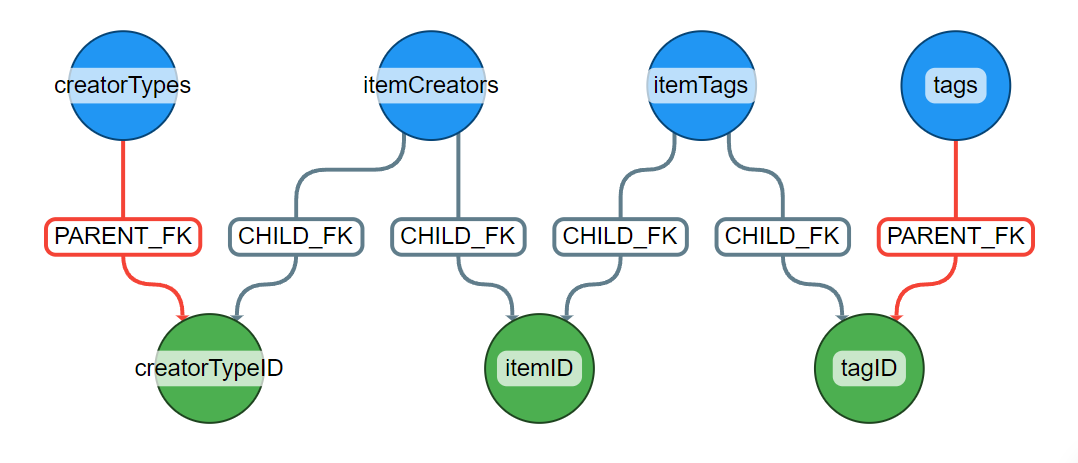

In [158]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/creatorTypesToTagsShortestPath.png"

# Display the PNG file
Image(filename=png_path)

#### Key takeaway from creating a Data KG

1. Doesn't rely on documentation


2. Read and ingest directly from metadata


3. A few lines of code to do the ETL and Cypher query design


4. Immediately see the shortest join path between table(s) 


5. Works for all types of databases and datastores

